In [1]:
import os
os.chdir("/workspace/")
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from LinLanDeepLearningFrame.ImageGeneratorModel.GANModel import *
from LinLanDeepLearningFrame.ImageGeneratorModel.VAEModel import *
from LinLanDeepLearningFrame.ImageGeneratorModel.DiffusionModel import *
from LinLanDeepLearningFrame.ImageGeneratorModel.UnetModel import *
from LinLanDeepLearningFrame.ImageGeneratorModel.Losses import *
from LinLanDeepLearningFrame.ImageGeneratorModel.utils import *
from torchvision.utils import make_grid
from torch.utils.data import ConcatDataset, DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

In [2]:
# 定义数据预处理方式
transform = transforms.Compose([
    transforms.ToTensor(),
])
# 下载训练集和测试集
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
combined_dataset = ConcatDataset([train_dataset, test_dataset])

# 创建 DataLoader
batch_size = 256
dataloader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)

训练WGAN

In [3]:
device = "cuda"
image_shape = (1,28,28)
hidden_channels = 8
depth = 2
attention = (True, False)
in_dim = 32
g_model = WGAN_Generator(in_dim=in_dim, image_shape=image_shape, hidden_channels=hidden_channels, depth=depth, attention=attention).to(device)
d_model = WGAN_Discriminator(image_shape=image_shape, hidden_channels=hidden_channels, depth=depth).to(device)
g_opt = torch.optim.Adam(params=g_model.parameters(), lr=2e-4, betas=(0.5, 0.999))
d_opt = torch.optim.Adam(params=d_model.parameters(), lr=2e-4, betas=(0.5, 0.999))
print(f"生成器参数量:{count_model_params(g_model)}, 判别器参数量:{count_model_params(d_model)}")

生成器参数量:69257, 判别器参数量:11969


0/21: 100%|██████████| 274/274 [00:12<00:00, 21.91it/s]


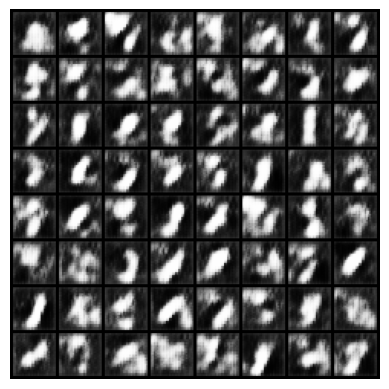

10/21: 100%|██████████| 274/274 [00:11<00:00, 24.21it/s]


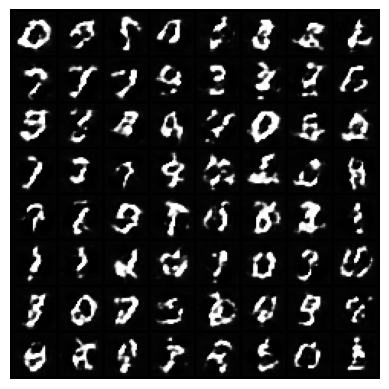

20/21: 100%|██████████| 274/274 [00:11<00:00, 24.13it/s]


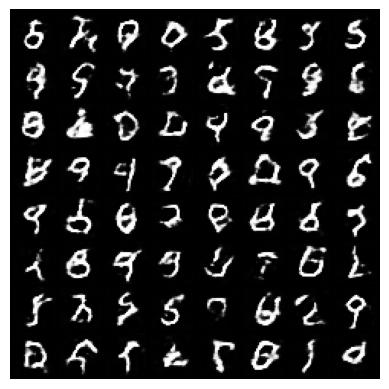

In [4]:
train_wgan_autocast(dataloader=dataloader, g_model=g_model, g_opt=g_opt, d_model=d_model, d_opt=d_opt, Epoch=21, valid=10, valid_size=64)

训练VAE

In [8]:
image_shape = (1,28,28)
depth = 2
attention = (True, False)
latent_dim = 4
hidden_channels = 8
vae = VAE2d(image_shape=image_shape, latent_dim=latent_dim, hidden_channels=hidden_channels, attention=attention, depth=depth).to(device)
vae_loss = VAELoss(beta=1, reduction="sum")
vae_opt = torch.optim.Adam(params=vae.parameters(), lr=1e-4)
print(f"vae模型参数量:{count_model_params(vae)}")

vae模型参数量:62511


0/21: 100%|██████████| 274/274 [00:09<00:00, 29.95it/s]


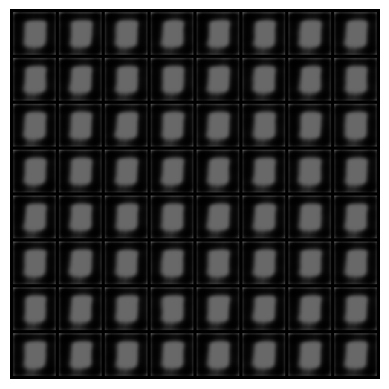

10/21: 100%|██████████| 274/274 [00:09<00:00, 30.00it/s]


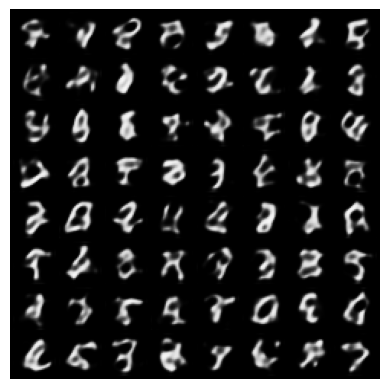

20/21: 100%|██████████| 274/274 [00:09<00:00, 29.88it/s]


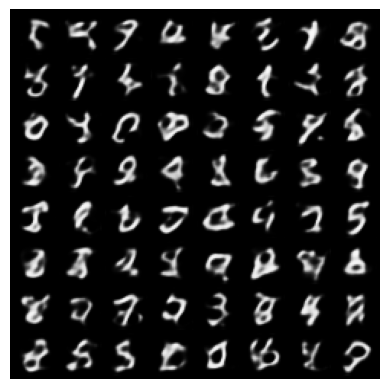

In [9]:
train_vae(dataloader=dataloader, model=vae, opt=vae_opt, loss_func=vae_loss, Epoch=21, valid_size=64, valid=10)

训练Diffusion

In [12]:
image_shape = (1,28,28)
hidden_channels = 8
depth = 2
attention=(True, False)
num_groups = 8
T=500
condition_dim = 32
schedule_name = "linear"
unet = Unet2dConditional(image_shape=image_shape, hidden_channels=hidden_channels, depth=depth, attention=attention, condition_dim=condition_dim, num_groups=num_groups)
ddpm = DDPM(model=unet, T=T, t_dim=condition_dim, image_shape=image_shape, schedule_name=schedule_name, device=device).to(device)
ddpm_opt = torch.optim.Adam(params=ddpm.parameters(), lr=1e-3)
print(f"diffusion模型参数量:{count_model_params(ddpm)}")

diffusion模型参数量:290913


generate: 100%|██████████| 500/500 [00:02<00:00, 171.38it/s]


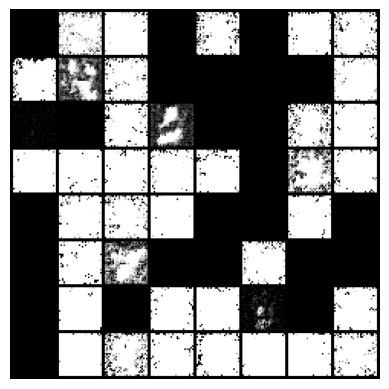

generate: 100%|██████████| 500/500 [00:02<00:00, 171.18it/s]


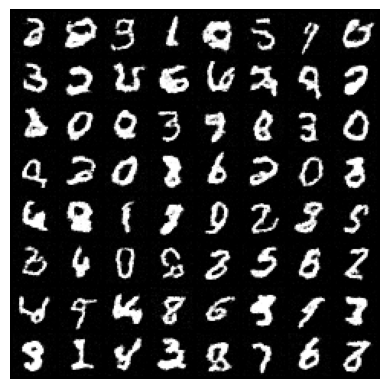

generate: 100%|██████████| 500/500 [00:02<00:00, 172.36it/s]


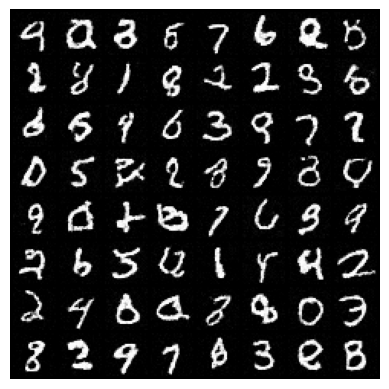

In [13]:
train_diffusion_autocast(dataloader=dataloader, model=ddpm, opt=ddpm_opt, Epoch=21, valid_size=64, valid=10)

In [ ]:
quit()